# 3 模型训练

## 3.1 准备工作

### 3.1.1 引入代码包

In [1]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split  # 切分数据
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 3.1.2 全局参数

In [2]:
id_col_names = ['user_id', 'coupon_id', 'date_received']
target_col_name = 'label'
id_target_cols = ['user_id', 'coupon_id', 'date_received', 'label']
myeval = 'roc_auc'
cvscore = 0

datapath = 'data/'
featurepath = 'feature/'
resultpath = 'result/'
tmppath = 'tmp/'
scorepath = 'score/'

### 3.1.3 特征读取

In [3]:
# 返回 ID 列
def get_id_df(df):
    return df[id_col_names]


#返回 Target 列
def get_target_df(df):
    return df[target_col_name]


# 返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]


# 按特征名读取训练集
def read_featurefile_train(featurename):
    df = pd.read_csv(featurepath + 'train_' + featurename + '.csv', sep=',', encoding='utf-8')
    df.fillna(0, inplace=True)
    return df


# 按特征名读取测试集
def read_featurefile_test(featurename):
    df = pd.read_csv(featurepath + 'test_' + featurename + '.csv', sep=',', encoding='utf-8')
    df.fillna(0, inplace=True)
    return df


# 按特征名读取数据
def read_data(featurename):
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf, testdf

### 3.1.4 模型训练代码

In [4]:
# 将特征归一化
def standize_df(train_data, test_data):
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])

    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])

    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns

    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns

    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler, test_data_scaler

In [5]:
def get_sklearn_model(model_name):
    # 朴素贝叶斯
    if model_name == 'NB':
        return MultinomialNB(alpha=0.01)

    # 逻辑回归
    elif model_name == 'LR':
        return LogisticRegression(penalty='l2')

    # KNN
    elif model_name == 'KNN':
        return KNeighborsClassifier()

    # 随机森林
    elif model_name == 'RF':
        return RandomForestClassifier()

    # 决策树
    elif model_name == 'DT':
        return tree.DecisionTreeClassifier()

    # 向量机
    elif model_name == 'SVC':
        return SVC(kernel='rbf')

    # GBDT
    elif model_name == 'GBDT':
        return GradientBoostingClassifier()

    # XGBoost
    elif model_name == 'XGB':
        return XGBClassifier()

    # LightGBM
    elif model_name == 'LGB':
        return LGBMClassifier()
    else:
        print('Wrong model name')


# 画学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt


# 画算法的学习曲线，为加快画图速度，最多选 20% 数据
def plot_curve_single(traindf, classifier, cvnum, train_sizes=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    X = get_predictors_df(traindf)
    y = get_target_df(traindf)
    estimator = get_sklearn_model(classifier)
    title = 'learning curve of ' + classifier + ', cv:' + str(cvnum)
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)


# 性能评价函数
#     目标是预测投放的优惠券是否核销
#     针对此任务及一些相关背景知识，使用优惠券核销预测的平均 AUC（ROC 曲线下面积）作为评价标准
#     即对每个优惠券 coupon_id 单独计算核销预测的 AUC 值，再对所有优惠券的 AUC 值求平均作为最终的评价标准
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)


# 按照日期分割
def test_model(traindf, classifier):
    train = traindf[traindf.date_received < 20160515].copy()
    test = traindf[traindf.date_received >= 20160515].copy()

    train_data = get_predictors_df(train).copy()
    train_target = get_target_df(train).copy()
    test_data = get_predictors_df(test).copy()
    test_target = get_target_df(test).copy()

    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:, 1]
    test['pred'] = result
    score = metrics.roc_auc_score(test_target, result)
    print(classifier + ' 总体 AUC:', score)
    score_coupon = myauc(test)
    print(classifier + ' Coupon AUC:', score_coupon)


def test_model_split(traindf, classifier):
    target = get_target_df(traindf).copy()

    train_all, test_all, train_target, test_target = train_test_split(traindf, target, test_size=0.2, random_state=0)

    train_data = get_predictors_df(train_all).copy()
    test_data = get_predictors_df(test_all).copy()

    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:, 1]

    test = test_all.copy()
    test['pred'] = result

    score = metrics.roc_auc_score(test_target, result)
    print(classifier + ' 总体 AUC:', score)
    score_coupon = myauc(test)
    print(classifier + ' Coupon AUC:', score_coupon)

## 3.2 简单特征 f1 训练

### 3.2.1 数据读取

In [6]:
# 所有的特征都是上一节生成的
train_f1, test_f1 = read_data('f1')

# 因为要使用 KNN 等进行测试，所以需要归一化
train_f1, test_f1 = standize_df(train_f1, test_f1)

In [7]:
train_f1.shape

(304509, 9)

In [8]:
train_f1['label'].sum()

np.int64(27878)

In [9]:
train_f1.head()

,discount_rate,distance,if_fd,full_value,reduction_value,label,user_id,coupon_id,date_received
0,0.812785,0.1,1.0,0.500000,0.20,0,1439408,11002,20160528
1,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160613
2,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160516
3,0.761035,0.0,1.0,0.100000,0.05,0,2029232,1532,20160530
4,0.939117,0.0,1.0,0.066667,0.01,0,2029232,12737,20160519


### 3.2.2 逻辑回归

In [10]:
test_model(train_f1, 'LR')

LR 总体 AUC: 0.6722908622853694
LR Coupon AUC: 0.5381247617281083


LR Coupon AUC


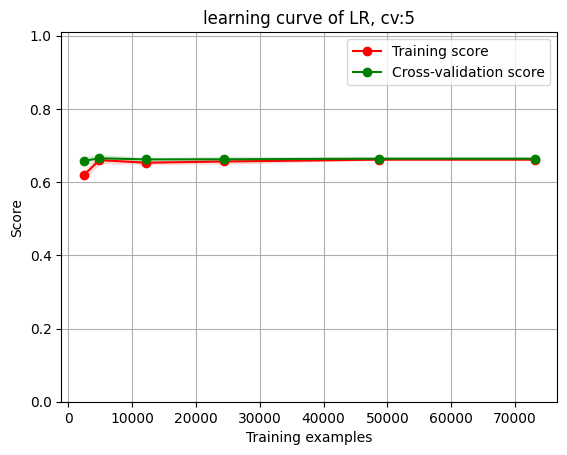

In [11]:
print('LR Coupon AUC')
plot_curve_single(train_f1, 'LR', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

### 3.2.3 朴素贝叶斯

In [12]:
test_model(train_f1, 'NB')

NB 总体 AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647


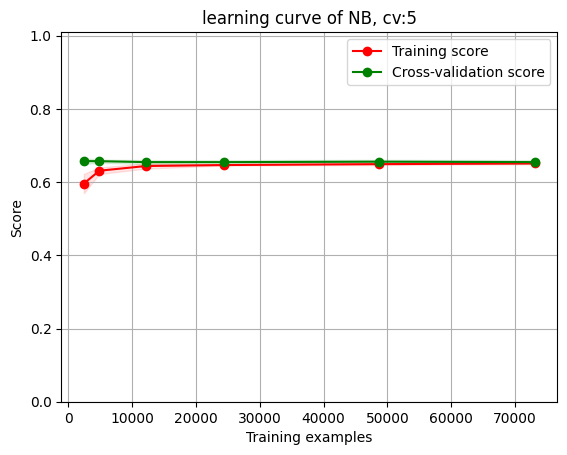

In [13]:
plot_curve_single(train_f1, 'NB', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

### 3.2.4 决策树

In [14]:
test_model(train_f1, 'DT')

DT 总体 AUC: 0.6481735302350922
DT Coupon AUC: 0.5303272197800327


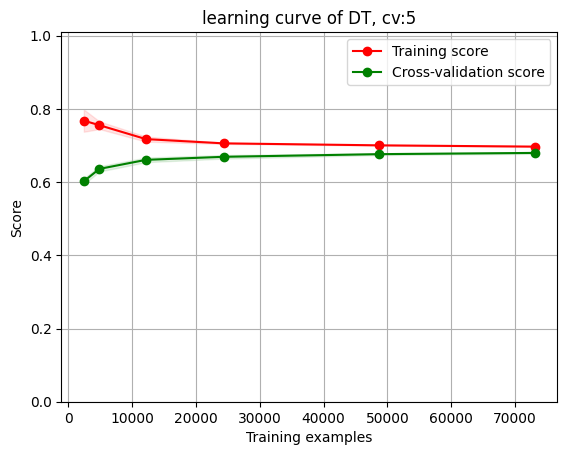

In [15]:
plot_curve_single(train_f1, 'DT', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

### 3.2.5 随机森林

In [16]:
test_model(train_f1, 'RF')

RF 总体 AUC: 0.6483701442618546
RF Coupon AUC: 0.530319707317786


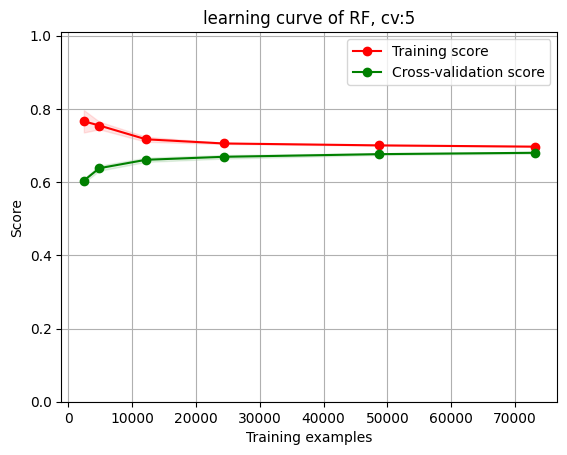

In [17]:
plot_curve_single(train_f1, 'RF', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

### 3.2.6 LightGBM

In [18]:
test_model(train_f1, 'LGB')

[LightGBM] [Info] Number of positive: 4748, number of negative: 42635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 47383, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100205 -> initscore=-2.194952
[LightGBM] [Info] Start training from score -2.194952
LGB 总体 AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097


[LightGBM] [Info] Number of positive: 47, number of negative: 2389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019294 -> initscore=-3.928483
[LightGBM] [Info] Start training from score -3.928483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


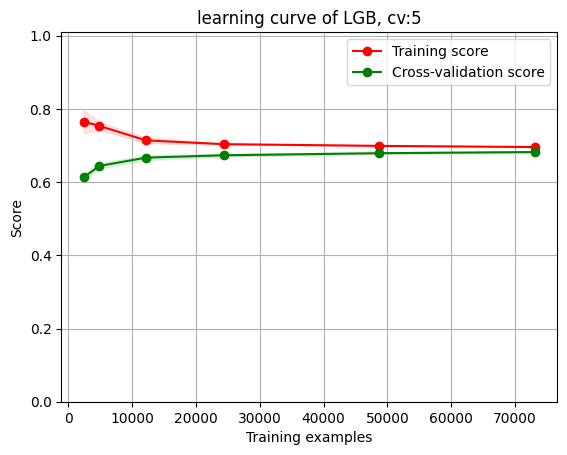

In [19]:
plot_curve_single(train_f1, 'LGB', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

### 3.2.7 XGBoost

In [20]:
test_model(train_f1, 'XGB')

XGB 总体 AUC: 0.653536917078787
XGB Coupon AUC: 0.5312927198383608


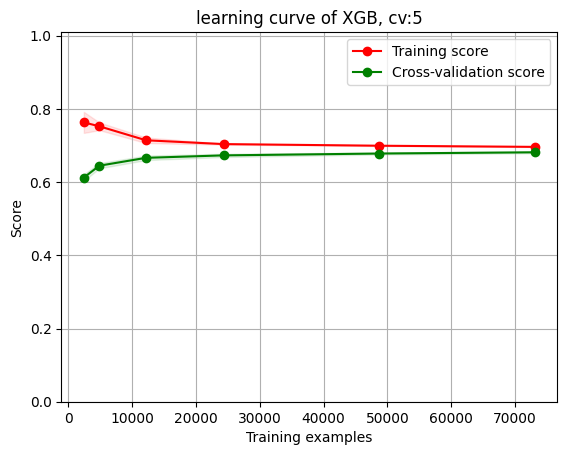

In [21]:
plot_curve_single(train_f1, 'XGB', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

## 3.3 用不同的特征训练并对比分析

### 3.3.1 读取数据

In [22]:
# 所有的特征都是上一节生成的
train_f2, test_f2 = read_data('sf2')

# 因为要使用 KNN 等进行测试，所以需要归一化
train_f2, test_f2 = standize_df(train_f2, test_f2)

# 所有的特征都是上一节生成的
train_f3, test_f3 = read_data('sf3')

# 因为要使用 KNN 等进行测试，所以需要归一化
train_f3, test_f3 = standize_df(train_f3, test_f3)

In [23]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


### 3.3.2 对比分析

In [24]:
print('特征 f1 逻辑回归成绩')
test_model(train_f1, 'LR')
print('特征 sf2 逻辑回归成绩')
test_model(train_f2, 'LR')
print('特征 sf3 逻辑回归成绩')
test_model(train_f3, 'LR')

特征 f1 逻辑回归成绩
LR 总体 AUC: 0.6722908622853694
LR Coupon AUC: 0.5381247617281083
特征 sf2 逻辑回归成绩
LR 总体 AUC: 0.7589902297449305
LR Coupon AUC: 0.6019792722961924
特征 sf3 逻辑回归成绩
LR 总体 AUC: 0.8094540485011451
LR Coupon AUC: 0.7279054511711345


In [25]:
print('特征 f1 朴素贝叶斯成绩')
test_model(train_f1, 'NB')
print('特征 sf2 朴素贝叶斯成绩')
test_model(train_f2, 'NB')
print('特征 sf3 朴素贝叶斯成绩')
test_model(train_f3, 'NB')

特征 f1 朴素贝叶斯成绩
NB 总体 AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647
特征 sf2 朴素贝叶斯成绩
NB 总体 AUC: 0.7342418749946003
NB Coupon AUC: 0.6061122104908827
特征 sf3 朴素贝叶斯成绩
NB 总体 AUC: 0.7812536833968516
NB Coupon AUC: 0.7119101385059943


In [26]:
print('特征 f1 决策树成绩')
test_model(train_f1, 'DT')
print('特征 sf2 决策树成绩')
test_model(train_f2, 'DT')
print('特征 sf3 决策树成绩')
test_model(train_f3, 'DT')

特征 f1 决策树成绩
DT 总体 AUC: 0.6481609737147687
DT Coupon AUC: 0.5302514392404754
特征 sf2 决策树成绩
DT 总体 AUC: 0.5281376542832549
DT Coupon AUC: 0.520858711719914
特征 sf3 决策树成绩
DT 总体 AUC: 0.5767690898297233
DT Coupon AUC: 0.5708296039704306


In [27]:
print('特征 f1 随机森林成绩')
test_model(train_f1, 'RF')
print('特征 sf2 随机森林成绩')
test_model(train_f2, 'RF')
print('特征 sf3 随机森林成绩')
test_model(train_f3, 'RF')

特征 f1 随机森林成绩
RF 总体 AUC: 0.6480961064277656
RF Coupon AUC: 0.5300012911646785
特征 sf2 随机森林成绩
RF 总体 AUC: 0.6870490590676528
RF Coupon AUC: 0.5656603365083702
特征 sf3 随机森林成绩
RF 总体 AUC: 0.7724926604958502
RF Coupon AUC: 0.707791020155774


In [28]:
print('特征 f1 LightGBM 成绩')
test_model(train_f1, 'LGB')
print('特征 sf2 LightGBM 成绩')
test_model(train_f2, 'LGB')
print('特征 sf3 LightGBM 成绩')
test_model(train_f3, 'LGB')

特征 f1 LightGBM 成绩
[LightGBM] [Info] Number of positive: 4748, number of negative: 42635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 47383, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100205 -> initscore=-2.194952
[LightGBM] [Info] Start training from score -2.194952
LGB 总体 AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097
特征 sf2 LightGBM 成绩
[LightGBM] [Info] Number of positive: 10347, number of negative: 170693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] 

In [29]:
print('特征 f1 XGBoost 成绩')
test_model(train_f1, 'XGB')
print('特征 sf2 XGBoost 成绩')
test_model(train_f2, 'XGB')
print('特征 sf3 XGBoost 成绩')
test_model(train_f3, 'XGB')

特征 f1 XGBoost 成绩
XGB 总体 AUC: 0.653536917078787
XGB Coupon AUC: 0.5312927198383608
特征 sf2 XGBoost 成绩
XGB 总体 AUC: 0.7276705941304202
XGB Coupon AUC: 0.5847156630995386
特征 sf3 XGBoost 成绩
XGB 总体 AUC: 0.8048806887790168
XGB Coupon AUC: 0.7277223130300415


可以发现特征 f2 比特征 f1 的结果好很多，这是因为特征 2 使用滑窗方案，增加了很多统计特征。而特征 3 比特征又有了很大的提高，这是因为特征 3 增加了穿越特征。

对比 LightGBM 和 LR 的成绩可以发现对于本问题，LightGBM 有着更好的成绩。

### 3.3.3 结果输出

通过分析发现特征 sf3 版本通过 LightGBM 分析的结果不错。下一步要做的事就是输出结果。

In [30]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


In [31]:
# 预测函数
def classifier_df_simple(train_feat, test_feat, classifier):
    model = get_sklearn_model(classifier)
    model.fit(get_predictors_df(train_feat), get_target_df(train_feat))
    predicted = pd.DataFrame(model.predict_proba(get_predictors_df(test_feat))[:, 1])
    return predicted


# 输出结果函数
def output_predicted(predicted, test_feat):
    predicted = round(predicted, 3)
    resultdf = get_id_df(test_feat).copy()
    resultdf['Probability'] = predicted
    return resultdf

In [32]:
predicted = classifier_df_simple(train_f3, test_f3, 'LGB')

[LightGBM] [Info] Number of positive: 33477, number of negative: 404689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 438166, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076403 -> initscore=-2.492260
[LightGBM] [Info] Start training from score -2.492260


In [33]:
predicted.head()

,0
0,0.007423
1,0.132002
2,0.006900
3,0.012854
4,0.035856


In [34]:
# 生成结果数据
result = output_predicted(predicted, test_f3)
result.head()

,user_id,coupon_id,date_received,Probability
0,4129537,9983,20160712,0.007
1,6949378,3429,20160706,0.132
2,2166529,6928,20160727,0.007
3,2166529,1808,20160727,0.013
4,6172162,6500,20160708,0.036


In [35]:
# 输出结果
result.to_csv('sf3_lgb.csv', header=False, index=False, sep=',')

在代码目录下生成了文件 sf3_lgb.csv。